# GCC218 - Algoritmos em Grafos
## Desafio - ShopMais

`Breno Oliveira - 2015`

`Guilherme Baviera - 20`

`Guilherme Henrique Haddad - 201520615`



## Fase 0

#### 1 - Leitura do arquivo de entrada
#### 2 - Sumarização
#### 3 - Visualização dos dados

In [1]:
with open('__InstanciaTeste.txt') as file:
    N = int(file.readline())
    R = int(file.readline())
    K = int(file.readline())
    H = int(file.readline())
    centros_distribuicao = [file.readline().split() for i in range(R)]
    clientes = ["".join([file.readline(), "-1"]).split() for i in range(N-R)]
    vehicles = [file.readline().split(' ') for i in range(K)]
    

#### Exibição Inicial

Nesse bloco, serão mostrados os Centro de Distribuição (vermelhos) e o Cliente (azul).

Isto ajuda a elucidar a distribuição dos clientes para esse problema.

In [2]:
from matplotlib import pyplot as plt
import random
#para todos os centros:
plt.scatter([float(x) for x,_,_,_,_ in centros_distribuicao], [float(y) for _,y,_,_,_ in centros_distribuicao], color='red')
#para todos os clientes
plt.scatter([float(x) for x,_,_,_,_,_ in clientes], [float(y) for _,y,_,_,_,_ in clientes], color='blue')


#axis = Define os limites do plano. Nesse caso é definido como igual tanto para min,máx dos eixos X e Y.
plt.axis('equal')

#xlabel ou xlabel = Define o "nome" de cada eixo, nesse caso mantemos como X e Y
plt.xlabel("x")
plt.ylabel("y")

#show = exibe a plotagem dos pontos no plano cartesiano
plt.show()

<Figure size 640x480 with 1 Axes>

# Fase 1

## Primeira Abordagem
Para cada `cliente (vértice)` calcule o `centro de distribuição` mais próximo.

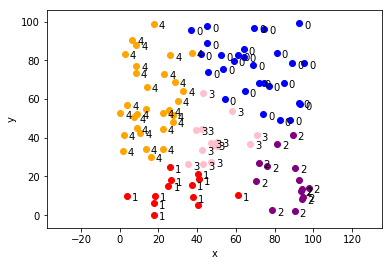

In [3]:
import sys
import math

colors = ['blue', 'red', 'purple', 'pink', 'orange']

#Fórmula para cálculo de distância Euclidiana entre dois pontos no plano cartesiano
def euclidian_distance(x1, y1, x2, y2):
    return math.sqrt((x2-x1)**2+(y2-y1)**2)


for i,[point_x,point_y,_,_,_,_] in enumerate(clientes):
    menor = sys.maxsize
    for j,[centros_distribuicao_x,centros_distribuicao_y,_,_,_] in enumerate(centros_distribuicao):
        if euclidian_distance(float(point_x), float(point_y), float(centros_distribuicao_x), float(centros_distribuicao_y)) < menor:
            menor = euclidian_distance(float(point_x), float(point_y), float(centros_distribuicao_x), float(centros_distribuicao_y))
            clientes[i][5] = j


for idx,[x,y,_,_,_] in enumerate(centros_distribuicao):
    plt.scatter(float(x), float(y), color=colors[idx])

for x,y,_,_,_,dist in clientes:
    plt.scatter(float(x), float(y), color=colors[dist])
    
for p in clientes:
    plt.annotate(p[5], xy=(float(p[0]),float(p[1])), xytext=(5,-5), textcoords='offset points')
    
plt.axis('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## Segunda Abordagem

Utilizar o `diagrama de Voronoi` para `clusterizar` as regiões

Mais informações, leia: https://pt.wikipedia.org/wiki/Diagrama_de_Voronoy

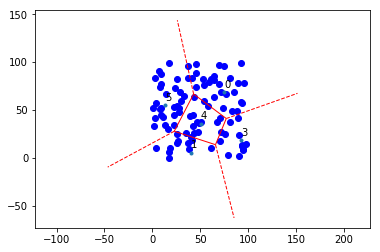

In [4]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import numpy as np

vor = Voronoi([(float(x),float(y)) for x,y,_,_,_ in centros_distribuicao])
voronoi_plot_2d(vor, line_colors='red', show_vertices=False)

for idx,d in enumerate(centros_distribuicao):
    plt.annotate(vor.point_region[idx], xy=(float(d[0]),float(d[1])), xytext=(0,5), textcoords='offset points')
    
for x,y,_,_,_,_ in clientes:
    plt.scatter(float(x), float(y), color='blue')
plt.axis('equal')

plt.show()

point = Point(0, 0)
polygon = Polygon([vor.vertices[i] for i in vor.regions[5] if not i == '-1'])
#print(polygon.contains(point))

#print("ridge_points\n", vor.ridge_points)
#print("ridge_vertices\n", vor.ridge_vertices)
#print("vertices\n", vor.vertices)
#print("regions\n", vor.regions)
#print("points\n", vor.points)
#print("point_region\n", vor.point_region)

## Transformação para regiões finitas

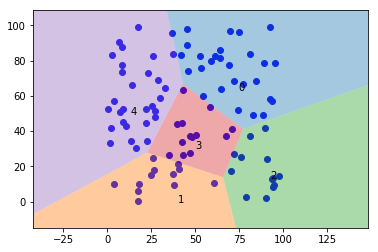

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon

def voronoi_with_finite_polygons(vor):
    """
    
    """

    new_regions = []
    # Vértices do diagrama de voronoi
    new_vertices = vor.vertices.tolist()
    # Ponto médio entre os centros de distribuição
    center = vor.points.mean(axis=0)
    
    # Atualiza raio que dará a posição do vértice, d'antes infinito, no novo polígono
    radius = vor.points.ptp().max()*2

    # Estrutura para armazenar os vértices de voronoi que se cruza ao sair de um ponto de distribuição para um outro qualquer de região vizinha
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
        
    # Cálculo das regiões infinitas
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        
        # Se nenhum dos pontos da região possui um vértice no infinito
        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]

        # Vértices que não estão no infinito
        new_region = [v for v in vertices if v >= 0]
        
        for idx, [p2, v1, v2] in enumerate(ridges):
            #print(p1, p2, v1, v2)
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # Ridge finita que já consta na região
                continue

            # Computa os pontos infinitos na região
            t = vor.points[p2] - vor.points[p1] # tangente
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            # Atualiza all_ridges com os novos vértices calculados
            v1 = len(new_vertices)
            ridges[idx] = [p2, v1, v2]
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        
        # Ordena as regiões de forma anti-horária
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices), all_ridges

dists = np.array([[float(x),float(y)] for x,y,_,_,_ in centros_distribuicao])

# Cria diagrama de Voronoi
vor = Voronoi(dists)

# Transforma pontos infinitos em finitos
regions, vertices, all_ridges = voronoi_with_finite_polygons(vor)

# TODO: pegar valor max e min dos pontos de entrega e não dos pontos de distribuição
min_x = vor.min_bound[0] - 1000
max_x = vor.max_bound[0] + 1000
min_y = vor.min_bound[1] - 1000
max_y = vor.max_bound[1] + 1000

mins = np.tile((min_x, min_y), (vertices.shape[0], 1))
bounded_vertices = np.max((vertices, mins), axis=0)
maxs = np.tile((max_x, max_y), (vertices.shape[0], 1))
bounded_vertices = np.min((bounded_vertices, maxs), axis=0)

# Polígono geral do gráfico
box = Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])

new_regions = []

for region in regions:
    polygon = vertices[region]
    # Clipping polygon
    poly = Polygon(polygon)
    poly = poly.intersection(box)
    polygon = [p for p in poly.exterior.coords]
    new_regions.append(poly)

    plt.fill(*zip(*polygon), alpha=0.4)

new_points = []
# Plota os pontos de entrega
for x,y,_,_,_,_ in clientes:
    plt.scatter(float(x), float(y), color='blue')
    for idx,region in enumerate(new_regions):
        if region.contains(Point(float(x), float(y))):
            # Imprime índice da região do ponto
            new_points.append([x,y,idx])
            #print(idx)


# Plota os indices das regiões
for idx,[x,y] in enumerate(dists):
    plt.annotate(idx, xy=(x,y), xytext=(0,-10), textcoords='offset points')

plt.axis('equal')
plt.xlim(vor.min_bound[0] - 20.1, vor.max_bound[0] + 20.1)
plt.ylim(vor.min_bound[1] - 20.1, vor.max_bound[1] + 40.1)

plt.show()

## Heurística para melhoramento das divisões das regiões

A ideia utilizada:

1. Ordenar as regiões, de forma decrescente, de acordo com a quantidade de pontos de entrega contidos nas mesmas.

2. As regiões com mais pontos irão _doar_ os pontos mais próximos de outra região com menos pontos

    2.1 Para isso, calculamos o ponto mais proximo da ridge entre duas regiões
    
    2.2 Calculamos em qual posição do polígono este ponto será inserido
    
    2.3 Atualiza as duas regiões (polígonos) com o novo vértice


# Resultado da Fase 1

## Clientes

In [6]:
from cliente import Cliente

lista_de_clientes = []

for idx, point in enumerate(clientes):
    coordernadas = []
    coordernadas.append(point[0])
    coordernadas.append(point[1])
    volume = float(point[2])
    preco_mercadoria = float(point[3])
    qtd_pacotes = float(point[4])
    regiao = point[5]
    qtd_vizinhos = len(clientes)
    #Criada lista de Objetos do Tipo CLIENTE
    lista_de_clientes.append(Cliente(coordernadas, volume, preco_mercadoria, qtd_pacotes, regiao, idx, qtd_vizinhos))

j = 0
for i in clientes:
    print(lista_de_clientes[j])
    j+=1

Cliente: 0	 Volume do Pedido: 0.006231201587448851	 Qtd Pacotes: 10.0
Cliente: 1	 Volume do Pedido: 0.004195124076695851	 Qtd Pacotes: 1.0
Cliente: 2	 Volume do Pedido: 0.006345006337636048	 Qtd Pacotes: 3.0
Cliente: 3	 Volume do Pedido: 0.007503632190101092	 Qtd Pacotes: 8.0
Cliente: 4	 Volume do Pedido: 0.008467447889896756	 Qtd Pacotes: 11.0
Cliente: 5	 Volume do Pedido: 0.0066742951516958575	 Qtd Pacotes: 1.0
Cliente: 6	 Volume do Pedido: 0.0025034933794928676	 Qtd Pacotes: 7.0
Cliente: 7	 Volume do Pedido: 0.004500594156230166	 Qtd Pacotes: 6.0
Cliente: 8	 Volume do Pedido: 0.0015682888468664183	 Qtd Pacotes: 3.0
Cliente: 9	 Volume do Pedido: 0.007944209312914306	 Qtd Pacotes: 9.0
Cliente: 10	 Volume do Pedido: 0.003518377767389935	 Qtd Pacotes: 5.0
Cliente: 11	 Volume do Pedido: 0.0015004710714624102	 Qtd Pacotes: 2.0
Cliente: 12	 Volume do Pedido: 0.001651307867175865	 Qtd Pacotes: 4.0
Cliente: 13	 Volume do Pedido: 0.008164527003619398	 Qtd Pacotes: 4.0
Cliente: 14	 Volume do P

## Centros

In [ ]:
from centro import Centro

#Instancia os centros de distribuicao
centros = []

for idx, center in enumerate(distribuitions):
    coordenadas = []
    coordenadas.append(center[0])
    coordenadas.append(center[1])
    clientes_do_centro = []
    #  Pega todos os clientes que pertencem ao centro em questao
    clientes_do_centro = [cliente for cliente in clientes if cliente.get_centro() == idx]
    label = idx

    centros.append(Centro(coordenadas, clientes_do_centro, label))